### Import the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style('darkgrid')
# %matplotlib inline

df = pd.read_csv('winequality-red.csv')

In [2]:
# Have a look at the first five rows
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
break

### Exploratory Data Analysis

In [3]:
# Create a proflie report on the data
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()  # Save widgets to cell
profile.to_file("Wine report.html")  # Save report in html extension

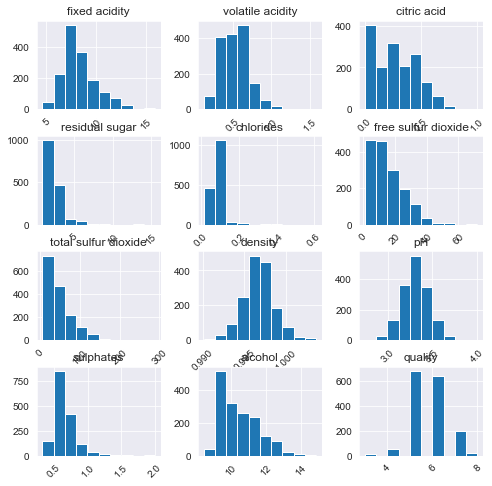

In [4]:
# Plot distributions of numeric features
df.hist(figsize=(8, 8), xrot=45)
plt.show()

As all features except for targeted one are skewedly or normally distributed, we can apply normalization to all

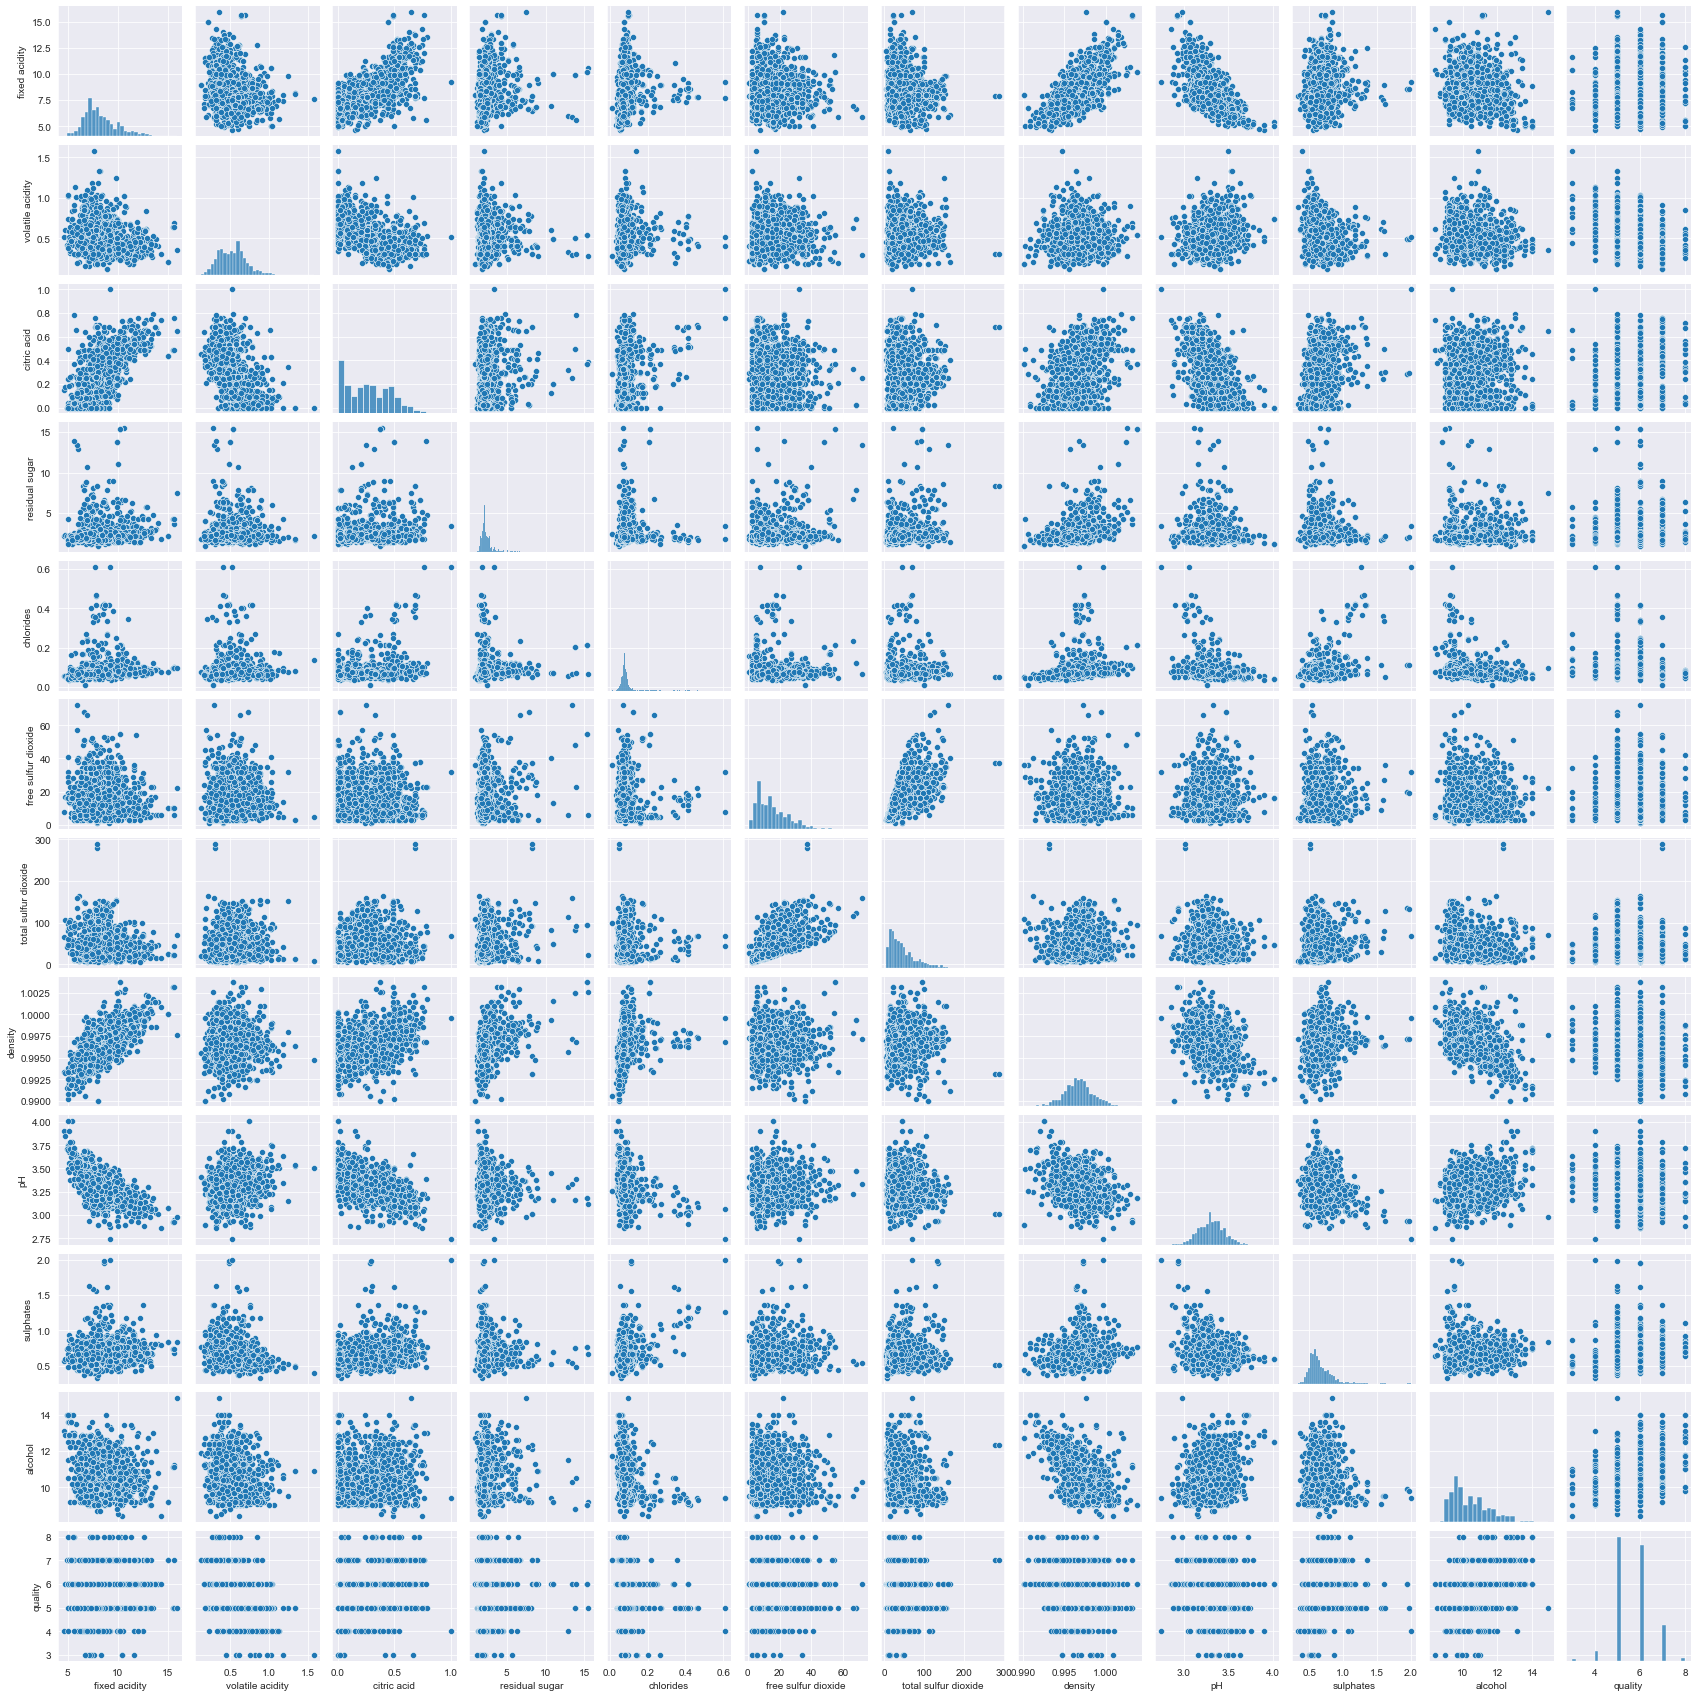

In [5]:
sb.pairplot(df, height=2)

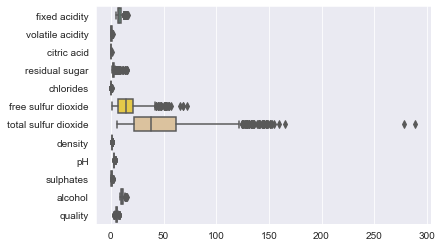

In [6]:
# Have a look at outliers
ax = sb.boxplot(data=df, orient="h", palette="Set2")

As quality 3 and 8 are underrepresented, we may have to use sampling techniques

### Data cleaning and manipulation

In [7]:
def to_cat(df):
    '''For columns that have few number of unique values (< 0.05), convert to category to save memory'''
    cols = df.columns
    for col in cols:
        ratio = df[col].nunique() / len(df)
        if ratio < 0.05:
            df[col] = df[col].astype('category')
    return df


def drop_dup(df):
    '''Remove duplicates from df'''
    df = df.drop_duplicates()
    return df


df = (df.
      pipe(to_cat).
      pipe(drop_dup))

In [8]:
X = df.drop(columns='quality').copy()
y = df.quality.copy()

In [9]:
# Use SMOTEENN to sampling classes
from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state=1)
X, y = sme.fit_resample(X, y)

In [10]:
# Retrive num_cols and cat_cols
num_cols = list(X._get_numeric_data().columns)
cat_cols = list(set(X.columns) - set(num_cols))

In [11]:
# StandardScale the dataset and convert it back to dataframe type
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled_X = sc.fit_transform(X)
X = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

### Build XGB model paired with Optuna

In [13]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna
import pickle


def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'num_leaves': trial.suggest_int('num_leaves', 6, 50),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001]),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500),
        'min_child_weight': trial.suggest_categorical('min_child_weight',
                                                      [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]),
        'subsample': trial.suggest_loguniform('subsample', 0.2, 0.8),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.4, 0.6),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0, 1e-1, 1, 5, 10, 20, 50, 100])
    }
    model = XGBClassifier(**param, obejctive='multi:softmax', num_classes=len(y.unique()))
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    return cross_val_score(model, X, y,
                           n_jobs=-1, cv=StratifiedKFold(10)).mean()

In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-04-13 21:49:13,352] A new study created in memory with name: no-name-d9493e66-0ff6-4adc-873d-0eccf263738f
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:20,060] Trial 0 finished with value: 0.9524324324324326 and parameters: {'max_depth': 34, 'num_leaves': 48, 'learning_rate': 0.1, 'min_child_samples': 344, 'min_child_weight': 0.001, 'subsample': 0.4683579261516278, 'colsample_bytree': 0.5559333734654567, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:21,035] Trial 1 finished with value: 0.26432432432432434 and parameters: {'max_depth': 24, 'num_leaves': 8, 'learning_rate': 0.001, 'min_child_samples': 324, 'min_child_weight': 100.0, 'subsample': 0.3295931455128879, 'colsample_bytree': 0.5280079839849445, 'reg_alpha': 50, 'reg_lambda': 10}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:22,009] Trial 2 finished with value: 0.26432432432432434 and parameters: {'max_depth': 35, 'num_leaves': 7, 'learning_rate': 0.001, 'min_child_samples': 491, 'min_child_weight': 10000.0, 'subsample': 0.25892195725531414, 'colsample_bytree': 0.4697550226014864, 'reg_alpha': 100, 'reg_lambda': 0}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:23,000] Trial 3 finished with value: 0.26432432432432434 and parameters: {'max_depth': 47, 'num_leaves': 50, 'learning_rate': 0.1, 'min_child_samples': 434, 'min_child_weight': 1e-05, 'subsample': 0.24593076203535277, 'colsample_bytree': 0.41493323688336825, 'reg_alpha': 100, 'reg_lambda': 20}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:23,966] Trial 4 finished with value: 0.26432432432432434 and parameters: {'max_depth': 31, 'num_leaves': 38, 'learning_rate': 0.1, 'min_child_samples': 453, 'min_child_weight': 1000.0, 'subsample': 0.3668756582818649, 'colsample_bytree': 0.4853589522966168, 'reg_alpha': 100, 'reg_lambda': 5}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:25,902] Trial 5 finished with value: 0.845945945945946 and parameters: {'max_depth': 47, 'num_leaves': 16, 'learning_rate': 0.1, 'min_child_samples': 469, 'min_child_weight': 1, 'subsample': 0.21034975123063407, 'colsample_bytree': 0.5341645800253667, 'reg_alpha': 10, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:28,353] Trial 6 finished with value: 0.8329729729729729 and parameters: {'max_depth': 42, 'num_leaves': 9, 'learning_rate': 0.01, 'min_child_samples': 413, 'min_child_weight': 10.0, 'subsample': 0.5243913930514976, 'colsample_bytree': 0.42026272078449944, 'reg_alpha': 7, 'reg_lambda': 1}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:31,380] Trial 7 finished with value: 0.9254054054054054 and parameters: {'max_depth': 46, 'num_leaves': 48, 'learning_rate': 0.1, 'min_child_samples': 207, 'min_child_weight': 1, 'subsample': 0.3056966221016607, 'colsample_bytree': 0.533773145590785, 'reg_alpha': 2, 'reg_lambda': 5}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:32,386] Trial 8 finished with value: 0.26432432432432434 and parameters: {'max_depth': 35, 'num_leaves': 27, 'learning_rate': 0.1, 'min_child_samples': 407, 'min_child_weight': 10000.0, 'subsample': 0.5998639255707208, 'colsample_bytree': 0.5104258565234395, 'reg_alpha': 5, 'reg_lambda': 50}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:33,445] Trial 9 finished with value: 0.26432432432432434 and parameters: {'max_depth': 30, 'num_leaves': 33, 'learning_rate': 0.001, 'min_child_samples': 156, 'min_child_weight': 1000.0, 'subsample': 0.6478757137405069, 'colsample_bytree': 0.5961957666301313, 'reg_alpha': 1, 'reg_lambda': 0}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:38,585] Trial 10 finished with value: 0.8156756756756758 and parameters: {'max_depth': 10, 'num_leaves': 42, 'learning_rate': 0.01, 'min_child_samples': 295, 'min_child_weight': 0.001, 'subsample': 0.46882840337512954, 'colsample_bytree': 0.5998396449112299, 'reg_alpha': 0, 'reg_lambda': 100}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:42,871] Trial 11 finished with value: 0.9324324324324325 and parameters: {'max_depth': 21, 'num_leaves': 49, 'learning_rate': 0.1, 'min_child_samples': 179, 'min_child_weight': 0.01, 'subsample': 0.3151930861035187, 'colsample_bytree': 0.5650822170859046, 'reg_alpha': 2, 'reg_lambda': 5}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:47,774] Trial 12 finished with value: 0.9416216216216217 and parameters: {'max_depth': 19, 'num_leaves': 45, 'learning_rate': 0.1, 'min_child_samples': 277, 'min_child_weight': 0.01, 'subsample': 0.4269152216833803, 'colsample_bytree': 0.566595014312519, 'reg_alpha': 2, 'reg_lambda': 1}. Best is trial 0 with value: 0.9524324324324326.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:49:54,830] Trial 13 finished with value: 0.9545945945945947 and parameters: {'max_depth': 13, 'num_leaves': 43, 'learning_rate': 0.1, 'min_child_samples': 284, 'min_child_weight': 0.001, 'subsample': 0.44312578555890225, 'colsample_bytree': 0.5733903607340597, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 13 with value: 0.9545945945945947.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:01,879] Trial 14 finished with value: 0.9572972972972973 and parameters: {'max_depth': 11, 'num_leaves': 25, 'learning_rate': 0.1, 'min_child_samples': 351, 'min_child_weight': 0.001, 'subsample': 0.7763878256870379, 'colsample_bytree': 0.5687226861461216, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 14 with value: 0.9572972972972973.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:08,723] Trial 15 finished with value: 0.9470270270270271 and parameters: {'max_depth': 10, 'num_leaves': 24, 'learning_rate': 0.01, 'min_child_samples': 242, 'min_child_weight': 0.001, 'subsample': 0.7970977263782225, 'colsample_bytree': 0.597220647598473, 'reg_alpha': 0, 'reg_lambda': 1}. Best is trial 14 with value: 0.9572972972972973.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:14,631] Trial 16 finished with value: 0.9545945945945947 and parameters: {'max_depth': 14, 'num_leaves': 20, 'learning_rate': 0.1, 'min_child_samples': 364, 'min_child_weight': 0.1, 'subsample': 0.7466198353035508, 'colsample_bytree': 0.4609825142252701, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 14 with value: 0.9572972972972973.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:20,249] Trial 17 finished with value: 0.9594594594594594 and parameters: {'max_depth': 15, 'num_leaves': 19, 'learning_rate': 0.1, 'min_child_samples': 371, 'min_child_weight': 0.1, 'subsample': 0.7871281548452237, 'colsample_bytree': 0.4489405569992192, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 17 with value: 0.9594594594594594.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:25,756] Trial 18 finished with value: 0.9583783783783785 and parameters: {'max_depth': 17, 'num_leaves': 16, 'learning_rate': 0.1, 'min_child_samples': 100, 'min_child_weight': 0.1, 'subsample': 0.6844221351411499, 'colsample_bytree': 0.4380820993083214, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 17 with value: 0.9594594594594594.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:31,082] Trial 19 finished with value: 0.9605405405405406 and parameters: {'max_depth': 17, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 101, 'min_child_weight': 0.1, 'subsample': 0.6288067433799851, 'colsample_bytree': 0.43913328371435273, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 19 with value: 0.9605405405405406.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:37,869] Trial 20 finished with value: 0.9556756756756757 and parameters: {'max_depth': 26, 'num_leaves': 13, 'learning_rate': 0.01, 'min_child_samples': 126, 'min_child_weight': 0.1, 'subsample': 0.583576926118544, 'colsample_bytree': 0.4015814973404937, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 19 with value: 0.9605405405405406.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:43,435] Trial 21 finished with value: 0.9572972972972973 and parameters: {'max_depth': 17, 'num_leaves': 19, 'learning_rate': 0.1, 'min_child_samples': 105, 'min_child_weight': 0.1, 'subsample': 0.69281401539912, 'colsample_bytree': 0.4436371024380739, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 19 with value: 0.9605405405405406.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:48,947] Trial 22 finished with value: 0.9572972972972973 and parameters: {'max_depth': 16, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 103, 'min_child_weight': 0.1, 'subsample': 0.6950796829303663, 'colsample_bytree': 0.43795041319555666, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 19 with value: 0.9605405405405406.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:54,126] Trial 23 finished with value: 0.9545945945945947 and parameters: {'max_depth': 22, 'num_leaves': 21, 'learning_rate': 0.1, 'min_child_samples': 379, 'min_child_weight': 0.1, 'subsample': 0.5467917699170535, 'colsample_bytree': 0.44044726705552645, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 19 with value: 0.9605405405405406.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:50:59,539] Trial 24 finished with value: 0.9583783783783785 and parameters: {'max_depth': 27, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 140, 'min_child_weight': 0.1, 'subsample': 0.6445466485363793, 'colsample_bytree': 0.4245976264202177, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 19 with value: 0.9605405405405406.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:07,653] Trial 25 finished with value: 0.9616216216216216 and parameters: {'max_depth': 28, 'num_leaves': 12, 'learning_rate': 0.001, 'min_child_samples': 137, 'min_child_weight': 0.1, 'subsample': 0.7973872033469138, 'colsample_bytree': 0.41988421194596665, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:12,506] Trial 26 finished with value: 0.8794594594594596 and parameters: {'max_depth': 21, 'num_leaves': 10, 'learning_rate': 0.001, 'min_child_samples': 232, 'min_child_weight': 0.1, 'subsample': 0.7879047526035722, 'colsample_bytree': 0.45926875629516645, 'reg_alpha': 7, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:13,785] Trial 27 finished with value: 0.6010810810810812 and parameters: {'max_depth': 27, 'num_leaves': 31, 'learning_rate': 0.001, 'min_child_samples': 171, 'min_child_weight': 100.0, 'subsample': 0.7991494889169163, 'colsample_bytree': 0.4102336512121448, 'reg_alpha': 0.1, 'reg_lambda': 100}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:17,458] Trial 28 finished with value: 0.8383783783783784 and parameters: {'max_depth': 24, 'num_leaves': 6, 'learning_rate': 0.001, 'min_child_samples': 388, 'min_child_weight': 1e-05, 'subsample': 0.5171206979219548, 'colsample_bytree': 0.4000205703804024, 'reg_alpha': 5, 'reg_lambda': 10}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:19,816] Trial 29 finished with value: 0.6718918918918919 and parameters: {'max_depth': 39, 'num_leaves': 17, 'learning_rate': 0.001, 'min_child_samples': 335, 'min_child_weight': 10.0, 'subsample': 0.7321884514369309, 'colsample_bytree': 0.48273380984376435, 'reg_alpha': 50, 'reg_lambda': 50}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:23,171] Trial 30 finished with value: 0.8091891891891893 and parameters: {'max_depth': 32, 'num_leaves': 22, 'learning_rate': 0.001, 'min_child_samples': 203, 'min_child_weight': 0.1, 'subsample': 0.6109637512518256, 'colsample_bytree': 0.4526128412337493, 'reg_alpha': 10, 'reg_lambda': 20}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:28,543] Trial 31 finished with value: 0.958918918918919 and parameters: {'max_depth': 28, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 138, 'min_child_weight': 0.1, 'subsample': 0.6355619004991464, 'colsample_bytree': 0.4240707307773635, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:33,792] Trial 32 finished with value: 0.9572972972972973 and parameters: {'max_depth': 28, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 133, 'min_child_weight': 0.1, 'subsample': 0.49137692067486505, 'colsample_bytree': 0.42965228528553584, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:39,411] Trial 33 finished with value: 0.932972972972973 and parameters: {'max_depth': 39, 'num_leaves': 12, 'learning_rate': 0.001, 'min_child_samples': 118, 'min_child_weight': 0.1, 'subsample': 0.5577060299054817, 'colsample_bytree': 0.4085010476771693, 'reg_alpha': 1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:40,764] Trial 34 finished with value: 0.727027027027027 and parameters: {'max_depth': 34, 'num_leaves': 8, 'learning_rate': 0.1, 'min_child_samples': 312, 'min_child_weight': 100.0, 'subsample': 0.6559408621631969, 'colsample_bytree': 0.47184119391737167, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:46,378] Trial 35 finished with value: 0.8843243243243244 and parameters: {'max_depth': 24, 'num_leaves': 18, 'learning_rate': 0.001, 'min_child_samples': 165, 'min_child_weight': 0.1, 'subsample': 0.7578677016596412, 'colsample_bytree': 0.4281777635564394, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:47,372] Trial 36 finished with value: 0.26432432432432434 and parameters: {'max_depth': 14, 'num_leaves': 15, 'learning_rate': 0.1, 'min_child_samples': 258, 'min_child_weight': 10000.0, 'subsample': 0.3803476054552917, 'colsample_bytree': 0.4527998541451246, 'reg_alpha': 50, 'reg_lambda': 0}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:49,148] Trial 37 finished with value: 0.6627027027027027 and parameters: {'max_depth': 19, 'num_leaves': 6, 'learning_rate': 0.1, 'min_child_samples': 195, 'min_child_weight': 1e-05, 'subsample': 0.7115857494812773, 'colsample_bytree': 0.41716570990502566, 'reg_alpha': 100, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:50,122] Trial 38 finished with value: 0.26432432432432434 and parameters: {'max_depth': 38, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 497, 'min_child_weight': 1000.0, 'subsample': 0.6055377326453218, 'colsample_bytree': 0.5055266133772964, 'reg_alpha': 0.1, 'reg_lambda': 20}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:56,343] Trial 39 finished with value: 0.9470270270270269 and parameters: {'max_depth': 33, 'num_leaves': 23, 'learning_rate': 0.001, 'min_child_samples': 149, 'min_child_weight': 1, 'subsample': 0.6471564255882822, 'colsample_bytree': 0.4301792510465266, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:51:58,873] Trial 40 finished with value: 0.8205405405405406 and parameters: {'max_depth': 29, 'num_leaves': 8, 'learning_rate': 0.01, 'min_child_samples': 441, 'min_child_weight': 0.1, 'subsample': 0.2774114115321841, 'colsample_bytree': 0.4085196459864559, 'reg_alpha': 10, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:04,291] Trial 41 finished with value: 0.9605405405405406 and parameters: {'max_depth': 25, 'num_leaves': 15, 'learning_rate': 0.1, 'min_child_samples': 141, 'min_child_weight': 0.1, 'subsample': 0.6402519326952026, 'colsample_bytree': 0.42245172022470123, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:09,478] Trial 42 finished with value: 0.9578378378378378 and parameters: {'max_depth': 24, 'num_leaves': 16, 'learning_rate': 0.1, 'min_child_samples': 113, 'min_child_weight': 0.1, 'subsample': 0.567801510792234, 'colsample_bytree': 0.41851897902362184, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:13,346] Trial 43 finished with value: 0.9508108108108108 and parameters: {'max_depth': 25, 'num_leaves': 19, 'learning_rate': 0.1, 'min_child_samples': 181, 'min_child_weight': 0.1, 'subsample': 0.21257251439980288, 'colsample_bytree': 0.4482608035339351, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:15,788] Trial 44 finished with value: 0.8594594594594595 and parameters: {'max_depth': 22, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 147, 'min_child_weight': 10.0, 'subsample': 0.6397514014084835, 'colsample_bytree': 0.43168317240312126, 'reg_alpha': 7, 'reg_lambda': 50}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:19,569] Trial 45 finished with value: 0.9243243243243244 and parameters: {'max_depth': 30, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 413, 'min_child_weight': 0.01, 'subsample': 0.5038542904066559, 'colsample_bytree': 0.4652098916606146, 'reg_alpha': 5, 'reg_lambda': 5}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:23,933] Trial 46 finished with value: 0.8881081081081081 and parameters: {'max_depth': 12, 'num_leaves': 27, 'learning_rate': 0.1, 'min_child_samples': 477, 'min_child_weight': 0.1, 'subsample': 0.7284298069010396, 'colsample_bytree': 0.42195460379476674, 'reg_alpha': 1, 'reg_lambda': 100}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:25,436] Trial 47 finished with value: 0.6032432432432433 and parameters: {'max_depth': 36, 'num_leaves': 17, 'learning_rate': 0.1, 'min_child_samples': 221, 'min_child_weight': 1, 'subsample': 0.537185414366973, 'colsample_bytree': 0.4786188780907479, 'reg_alpha': 100, 'reg_lambda': 0}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:26,383] Trial 48 finished with value: 0.26432432432432434 and parameters: {'max_depth': 19, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 127, 'min_child_weight': 10000.0, 'subsample': 0.34281113926513307, 'colsample_bytree': 0.4122261054647338, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:27,362] Trial 49 finished with value: 0.26432432432432434 and parameters: {'max_depth': 31, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 169, 'min_child_weight': 1000.0, 'subsample': 0.6126501926846339, 'colsample_bytree': 0.4002440442399785, 'reg_alpha': 2, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:33,363] Trial 50 finished with value: 0.9524324324324326 and parameters: {'max_depth': 16, 'num_leaves': 15, 'learning_rate': 0.01, 'min_child_samples': 192, 'min_child_weight': 0.1, 'subsample': 0.45746922953149727, 'colsample_bytree': 0.5019389010801077, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:38,787] Trial 51 finished with value: 0.9583783783783785 and parameters: {'max_depth': 28, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 144, 'min_child_weight': 0.1, 'subsample': 0.6676833399118572, 'colsample_bytree': 0.4222707793646883, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:44,025] Trial 52 finished with value: 0.9583783783783785 and parameters: {'max_depth': 26, 'num_leaves': 18, 'learning_rate': 0.1, 'min_child_samples': 142, 'min_child_weight': 0.1, 'subsample': 0.6163913787044153, 'colsample_bytree': 0.42462534318394496, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:49,181] Trial 53 finished with value: 0.9572972972972975 and parameters: {'max_depth': 22, 'num_leaves': 20, 'learning_rate': 0.1, 'min_child_samples': 117, 'min_child_weight': 0.1, 'subsample': 0.579583621472019, 'colsample_bytree': 0.43544093218919583, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:52:54,569] Trial 54 finished with value: 0.9572972972972973 and parameters: {'max_depth': 17, 'num_leaves': 17, 'learning_rate': 0.1, 'min_child_samples': 109, 'min_child_weight': 0.1, 'subsample': 0.708324111215311, 'colsample_bytree': 0.4444475442624775, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:00,089] Trial 55 finished with value: 0.9567567567567569 and parameters: {'max_depth': 29, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 158, 'min_child_weight': 0.1, 'subsample': 0.7598261763122957, 'colsample_bytree': 0.4059684885379653, 'reg_alpha': 0.1, 'reg_lambda': 5}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:04,685] Trial 56 finished with value: 0.957837837837838 and parameters: {'max_depth': 26, 'num_leaves': 25, 'learning_rate': 0.1, 'min_child_samples': 100, 'min_child_weight': 0.1, 'subsample': 0.41172928825513244, 'colsample_bytree': 0.41639037505050713, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:09,993] Trial 57 finished with value: 0.9459459459459459 and parameters: {'max_depth': 14, 'num_leaves': 21, 'learning_rate': 0.1, 'min_child_samples': 354, 'min_child_weight': 0.01, 'subsample': 0.687573680895712, 'colsample_bytree': 0.4366693849671688, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:11,270] Trial 58 finished with value: 0.6935135135135135 and parameters: {'max_depth': 26, 'num_leaves': 37, 'learning_rate': 0.1, 'min_child_samples': 180, 'min_child_weight': 100.0, 'subsample': 0.7995151010323202, 'colsample_bytree': 0.4499488213048457, 'reg_alpha': 50, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:16,456] Trial 59 finished with value: 0.8681081081081082 and parameters: {'max_depth': 18, 'num_leaves': 7, 'learning_rate': 0.001, 'min_child_samples': 128, 'min_child_weight': 0.001, 'subsample': 0.6778589973000537, 'colsample_bytree': 0.4563799416851321, 'reg_alpha': 0, 'reg_lambda': 20}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:21,825] Trial 60 finished with value: 0.8875675675675675 and parameters: {'max_depth': 16, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 102, 'min_child_weight': 0.1, 'subsample': 0.7651059234284823, 'colsample_bytree': 0.4430679614104754, 'reg_alpha': 7, 'reg_lambda': 50}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:28,766] Trial 61 finished with value: 0.9610810810810813 and parameters: {'max_depth': 20, 'num_leaves': 16, 'learning_rate': 0.1, 'min_child_samples': 136, 'min_child_weight': 0.1, 'subsample': 0.6258542218514986, 'colsample_bytree': 0.4354901666989144, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:34,470] Trial 62 finished with value: 0.9583783783783785 and parameters: {'max_depth': 20, 'num_leaves': 15, 'learning_rate': 0.1, 'min_child_samples': 154, 'min_child_weight': 0.1, 'subsample': 0.6604741430813953, 'colsample_bytree': 0.4221876849695175, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:39,920] Trial 63 finished with value: 0.9583783783783785 and parameters: {'max_depth': 21, 'num_leaves': 18, 'learning_rate': 0.1, 'min_child_samples': 138, 'min_child_weight': 0.1, 'subsample': 0.6302062384065534, 'colsample_bytree': 0.4263100087707149, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:45,128] Trial 64 finished with value: 0.9583783783783785 and parameters: {'max_depth': 23, 'num_leaves': 19, 'learning_rate': 0.1, 'min_child_samples': 123, 'min_child_weight': 0.1, 'subsample': 0.5926044014934417, 'colsample_bytree': 0.43361938715503745, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:48,740] Trial 65 finished with value: 0.8729729729729729 and parameters: {'max_depth': 28, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 161, 'min_child_weight': 1e-05, 'subsample': 0.48506951901315637, 'colsample_bytree': 0.4124427943115615, 'reg_alpha': 2, 'reg_lambda': 100}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:52,643] Trial 66 finished with value: 0.8508108108108108 and parameters: {'max_depth': 50, 'num_leaves': 16, 'learning_rate': 0.001, 'min_child_samples': 329, 'min_child_weight': 0.1, 'subsample': 0.727629219128938, 'colsample_bytree': 0.4381492592963799, 'reg_alpha': 10, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:56,370] Trial 67 finished with value: 0.8945945945945946 and parameters: {'max_depth': 28, 'num_leaves': 10, 'learning_rate': 0.01, 'min_child_samples': 131, 'min_child_weight': 10.0, 'subsample': 0.6690809288647195, 'colsample_bytree': 0.4161783774649719, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:53:59,842] Trial 68 finished with value: 0.9232432432432433 and parameters: {'max_depth': 32, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 208, 'min_child_weight': 0.1, 'subsample': 0.551835836817086, 'colsample_bytree': 0.4046928339478083, 'reg_alpha': 5, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:05,916] Trial 69 finished with value: 0.9610810810810811 and parameters: {'max_depth': 11, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 312, 'min_child_weight': 0.1, 'subsample': 0.7980651124497902, 'colsample_bytree': 0.4453733850106395, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:06,892] Trial 70 finished with value: 0.26432432432432434 and parameters: {'max_depth': 10, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 277, 'min_child_weight': 10000.0, 'subsample': 0.7913801954571448, 'colsample_bytree': 0.4640485837884098, 'reg_alpha': 1, 'reg_lambda': 0}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:12,335] Trial 71 finished with value: 0.9545945945945945 and parameters: {'max_depth': 23, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 396, 'min_child_weight': 0.1, 'subsample': 0.5908770527473087, 'colsample_bytree': 0.43253824074319713, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:17,536] Trial 72 finished with value: 0.9567567567567569 and parameters: {'max_depth': 11, 'num_leaves': 15, 'learning_rate': 0.1, 'min_child_samples': 261, 'min_child_weight': 0.1, 'subsample': 0.6326386073835156, 'colsample_bytree': 0.4462772020151256, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:23,238] Trial 73 finished with value: 0.958918918918919 and parameters: {'max_depth': 13, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 376, 'min_child_weight': 0.1, 'subsample': 0.7396666552593121, 'colsample_bytree': 0.4275321861103146, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:28,835] Trial 74 finished with value: 0.9583783783783785 and parameters: {'max_depth': 15, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 376, 'min_child_weight': 0.1, 'subsample': 0.7352911861186067, 'colsample_bytree': 0.44081690112706406, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:35,625] Trial 75 finished with value: 0.9443243243243243 and parameters: {'max_depth': 12, 'num_leaves': 11, 'learning_rate': 0.001, 'min_child_samples': 311, 'min_child_weight': 0.1, 'subsample': 0.7961609577091301, 'colsample_bytree': 0.4706576543397721, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:41,133] Trial 76 finished with value: 0.9551351351351351 and parameters: {'max_depth': 13, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 426, 'min_child_weight': 0.1, 'subsample': 0.6961149661724456, 'colsample_bytree': 0.4280911004889439, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:45,917] Trial 77 finished with value: 0.952972972972973 and parameters: {'max_depth': 18, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 339, 'min_child_weight': 1, 'subsample': 0.7679894038786688, 'colsample_bytree': 0.4547008422474268, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:46,895] Trial 78 finished with value: 0.26432432432432434 and parameters: {'max_depth': 12, 'num_leaves': 13, 'learning_rate': 0.1, 'min_child_samples': 360, 'min_child_weight': 1000.0, 'subsample': 0.7256308252118139, 'colsample_bytree': 0.5470808773083319, 'reg_alpha': 0.1, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:49,455] Trial 79 finished with value: 0.5908108108108109 and parameters: {'max_depth': 15, 'num_leaves': 16, 'learning_rate': 0.001, 'min_child_samples': 375, 'min_child_weight': 0.1, 'subsample': 0.7506287505737157, 'colsample_bytree': 0.4189114650550452, 'reg_alpha': 100, 'reg_lambda': 1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:54:54,962] Trial 80 finished with value: 0.9464864864864865 and parameters: {'max_depth': 20, 'num_leaves': 7, 'learning_rate': 0.1, 'min_child_samples': 310, 'min_child_weight': 0.001, 'subsample': 0.7116173560768368, 'colsample_bytree': 0.4490563089165254, 'reg_alpha': 0.1, 'reg_lambda': 10}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:00,404] Trial 81 finished with value: 0.9572972972972973 and parameters: {'max_depth': 17, 'num_leaves': 14, 'learning_rate': 0.1, 'min_child_samples': 401, 'min_child_weight': 0.1, 'subsample': 0.6948319683585044, 'colsample_bytree': 0.43853925361455715, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:05,685] Trial 82 finished with value: 0.9551351351351351 and parameters: {'max_depth': 23, 'num_leaves': 19, 'learning_rate': 0.1, 'min_child_samples': 346, 'min_child_weight': 0.1, 'subsample': 0.566433114714704, 'colsample_bytree': 0.4255401588458241, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:11,087] Trial 83 finished with value: 0.9594594594594594 and parameters: {'max_depth': 30, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 418, 'min_child_weight': 0.1, 'subsample': 0.6454742403924459, 'colsample_bytree': 0.43013563632633806, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:16,178] Trial 84 finished with value: 0.9567567567567566 and parameters: {'max_depth': 31, 'num_leaves': 10, 'learning_rate': 0.1, 'min_child_samples': 420, 'min_child_weight': 0.1, 'subsample': 0.5239652291119193, 'colsample_bytree': 0.43041138644806404, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:18,352] Trial 85 finished with value: 0.7632432432432432 and parameters: {'max_depth': 30, 'num_leaves': 9, 'learning_rate': 0.1, 'min_child_samples': 439, 'min_child_weight': 0.1, 'subsample': 0.6286125127227357, 'colsample_bytree': 0.4128898522681916, 'reg_alpha': 50, 'reg_lambda': 5}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:19,577] Trial 86 finished with value: 0.7172972972972973 and parameters: {'max_depth': 13, 'num_leaves': 11, 'learning_rate': 0.1, 'min_child_samples': 446, 'min_child_weight': 100.0, 'subsample': 0.6636444345026861, 'colsample_bytree': 0.44199233243378167, 'reg_alpha': 0.1, 'reg_lambda': 20}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:25,691] Trial 87 finished with value: 0.9610810810810811 and parameters: {'max_depth': 25, 'num_leaves': 12, 'learning_rate': 0.1, 'min_child_samples': 391, 'min_child_weight': 0.1, 'subsample': 0.7725936950284777, 'colsample_bytree': 0.4346538446076827, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:33,939] Trial 88 finished with value: 0.9610810810810813 and parameters: {'max_depth': 25, 'num_leaves': 17, 'learning_rate': 0.01, 'min_child_samples': 401, 'min_child_weight': 0.01, 'subsample': 0.7739598329450195, 'colsample_bytree': 0.43347671603628085, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:42,274] Trial 89 finished with value: 0.9605405405405406 and parameters: {'max_depth': 27, 'num_leaves': 17, 'learning_rate': 0.01, 'min_child_samples': 391, 'min_child_weight': 1e-05, 'subsample': 0.7731231098066045, 'colsample_bytree': 0.4329616216234699, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 25 with value: 0.9616216216216216.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:50,537] Trial 90 finished with value: 0.9621621621621621 and parameters: {'max_depth': 25, 'num_leaves': 17, 'learning_rate': 0.01, 'min_child_samples': 456, 'min_child_weight': 1e-05, 'subsample': 0.7838946805241641, 'colsample_bytree': 0.43479957086583565, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:55:58,887] Trial 91 finished with value: 0.9610810810810813 and parameters: {'max_depth': 25, 'num_leaves': 17, 'learning_rate': 0.01, 'min_child_samples': 461, 'min_child_weight': 1e-05, 'subsample': 0.7996830306479944, 'colsample_bytree': 0.43307483136662944, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:56:07,240] Trial 92 finished with value: 0.9605405405405405 and parameters: {'max_depth': 25, 'num_leaves': 17, 'learning_rate': 0.01, 'min_child_samples': 455, 'min_child_weight': 1e-05, 'subsample': 0.7783969636023726, 'colsample_bytree': 0.43420073494770006, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:56:15,900] Trial 93 finished with value: 0.9621621621621621 and parameters: {'max_depth': 25, 'num_leaves': 20, 'learning_rate': 0.01, 'min_child_samples': 468, 'min_child_weight': 1e-05, 'subsample': 0.7933669685290089, 'colsample_bytree': 0.4196939201864888, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:56:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:56:24,412] Trial 94 finished with value: 0.9594594594594594 and parameters: {'max_depth': 25, 'num_leaves': 21, 'learning_rate': 0.01, 'min_child_samples': 481, 'min_child_weight': 1e-05, 'subsample': 0.7955213878736349, 'colsample_bytree': 0.4197243407966953, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:56:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:56:33,587] Trial 95 finished with value: 0.9610810810810813 and parameters: {'max_depth': 27, 'num_leaves': 20, 'learning_rate': 0.01, 'min_child_samples': 465, 'min_child_weight': 1e-05, 'subsample': 0.7740248953983117, 'colsample_bytree': 0.4228391135621125, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:56:43,060] Trial 96 finished with value: 0.9594594594594593 and parameters: {'max_depth': 27, 'num_leaves': 23, 'learning_rate': 0.01, 'min_child_samples': 466, 'min_child_weight': 1e-05, 'subsample': 0.7706525263186118, 'colsample_bytree': 0.4451151309587629, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:56:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:56:51,482] Trial 97 finished with value: 0.96 and parameters: {'max_depth': 27, 'num_leaves': 18, 'learning_rate': 0.01, 'min_child_samples': 492, 'min_child_weight': 1e-05, 'subsample': 0.7523860845773878, 'colsample_bytree': 0.4325648838171727, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:56:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:56:59,846] Trial 98 finished with value: 0.9616216216216218 and parameters: {'max_depth': 24, 'num_leaves': 20, 'learning_rate': 0.01, 'min_child_samples': 459, 'min_child_weight': 1e-05, 'subsample': 0.7746712843268787, 'colsample_bytree': 0.4055525162773437, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.
C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_classes, num_leaves, obejctive } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-13 21:57:07,812] Trial 99 finished with value: 0.9594594594594593 and parameters: {'max_depth': 24, 'num_leaves': 20, 'learning_rate': 0.01, 'min_child_samples': 462, 'min_child_weight': 1e-05, 'subsample': 0.7147482144812047, 'colsample_bytree': 0.40659253455779243, 'reg_alpha': 0, 'reg_lambda': 0.1}. Best is trial 90 with value: 0.9621621621621621.


In [15]:
print(f'Best score: {study.best_value}')

Best score: 0.9621621621621621


In [16]:
# Save the best model
with open("Best model.pickle", "wb") as fout:
    pickle.dump(XGBClassifier(**study.best_params), fout)

In [17]:
# save results
df_results = study.trials_dataframe()
df_results.to_pickle('./df_optuna_results.pkl')
df_results.to_csv('./df_optuna_results.csv')

In [18]:
# Build model with the best params
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

C:\Users\dtngh\miniconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.43479957086583565, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=25,
              min_child_samples=456, min_child_weight=1e-05, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_leaves=17, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=0.1,
              scale_pos_weight=None, subsample=0.7838946805241641,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
y_pred = best_model.predict(X_test)
y_pred = y_pred.astype(int)
y_pred = pd.DataFrame(y_pred, columns=['Quality'], index=X_test.index)
# saving the dataframe 
y_pred.to_csv('Predictions.csv') 